In [1]:
import gzip
import pickle
import matplotlib
import os
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import pystan
from matplotlib.ticker import MultipleLocator
from scipy.stats import gaussian_kde
import numpy as np
from datetime import datetime, timedelta
import warnings
import time
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
rcParams['figure.figsize'] = 16, 6
COMMON_SEED = 1234

In [3]:
def check_convergence(fit):
    report = print
    
    def all_rhat_small_enough(fit):
        return all(dict(fit.summary())['summary'][:, -1] < 1.1)
    
    def max_treedepth_exceeded(fit, max_depth = 10):
        """Check transitions that ended prematurely due to maximum tree depth limit"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        depths = [x for y in sampler_params for x in y['treedepth__']]
        n = sum(1 for x in depths if x == max_depth)
        if n > 0:
            report('Run again with max_depth set to a larger value to avoid saturation')        
        N = len(depths)
        report(('{} of {} iterations saturated the maximum tree depth of {}'
               + ' ({}%)').format(n, N, max_depth, 100 * n / N))
        return float(n) / N
    
    def e_bfmi_all_low_enough(fit):
        """
        Checks the energy Bayesian fraction of missing information (E-BFMI).
        E-BFMI below 0.2 indicates you may need to reparameterize your model
        """
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        for chain_num, s in enumerate(sampler_params):
            energies = s['energy__']
            numer = sum((energies[i] - energies[i - 1])**2 for i in range(1, len(energies))) / len(energies)
            denom = np.var(energies)
            if numer / denom < 0.2:
                report('Chain {}: E-BFMI = {}'.format(chain_num, numer / denom))
                report('E-BFMI below 0.2 indicates you may need to reparameterize your model')
                return False
        return True

    def fraction_of_transitions_which_ended_with_divergence(fit):
        """Check transitions that ended with a divergence"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        divergent = [x for y in sampler_params for x in y['divergent__']]
        n = sum(divergent)
        N = len(divergent)
        report('{} of {} iterations ended with a divergence ({}%)'
              .format(n, N, 100 * n / N))
        if n > 0:
            report('Try running with larger adapt_delta to remove the divergences')
        return n / N
    
    convergence_results = {
        "all_rhat_small_enough(fit)": all_rhat_small_enough(fit),
        "max_treedepth_exceeded(fit) < 0.02": max_treedepth_exceeded(fit) < 0.02,
        "e_bfmi_all_low_enough(fit)": e_bfmi_all_low_enough(fit),
        "fraction_of_transitions_which_ended_with_divergence(fit) <= 5E-3": 
            fraction_of_transitions_which_ended_with_divergence(fit) <= 5E-3
    }
    report(convergence_results)
    report("##### All convergence checks passed successfully. #####" if all(convergence_results.values()) else
          "##### Some convergence checks failed, see above. #####")

In [4]:
births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
births_2000s_df_with_index = births_2000s_df\
    .rename(columns={'date_of_month': 'day'})\
    .set_index(pd.to_datetime(
        births_2000s_df.rename(columns={'date_of_month': 'day'})
        [['year', 'month', 'day']]))\
    .assign(weekday_name=lambda df: df.index.weekday_name)\
    .assign(day_of_year=lambda df: df.index.dayofyear)\
    .assign(week_of_year=lambda df: df.index.weekofyear)
births_2000s_df_with_index.tail()

,year,month,day,day_of_week,births,weekday_name,day_of_year,week_of_year
2014-12-27,2014,12,27,6,8656,Saturday,361,52
2014-12-28,2014,12,28,7,7724,Sunday,362,52
2014-12-29,2014,12,29,1,12811,Monday,363,1
2014-12-30,2014,12,30,2,13634,Tuesday,364,1
2014-12-31,2014,12,31,3,11990,Wednesday,365,1


In [5]:
def get_train_and_test_for_sliding_window(test_date):
    num_data_points_before_first_test_date = datetime(2014, 1, 1) - datetime(2001, 1, 1)
    df = births_2000s_df_with_index[['day_of_week', 'births']]\
        [lambda df: df.index <= test_date + timedelta(days=6)]\
        [lambda df: df.index >= test_date - num_data_points_before_first_test_date]
    return {
        'x_train': df.index[:-7],
        'y_train': df.births[:-7].values,
        'x_test': df.index[-7:],
        'y_test': df.births[-7:].values
    }
        
get_train_and_test_for_sliding_window(datetime(2014, 1, 1))

{'x_test': DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
                '2014-01-05', '2014-01-06', '2014-01-07'],
               dtype='datetime64[ns]', freq=None),
 'x_train': DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04',
                '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08',
                '2001-01-09', '2001-01-10',
                ...
                '2013-12-22', '2013-12-23', '2013-12-24', '2013-12-25',
                '2013-12-26', '2013-12-27', '2013-12-28', '2013-12-29',
                '2013-12-30', '2013-12-31'],
               dtype='datetime64[ns]', length=4748, freq=None),
 'y_test': array([ 8018, 11171, 12317,  8199,  7174, 11400, 12310]),
 'y_train': array([ 7663, 10635, 12449, ...,  7896, 13096, 12525])}

In [6]:
def rmse(prediction_errors):
    return (prediction_errors ** 2).mean() ** 0.5

In [7]:
df = births_2000s_df_with_index

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

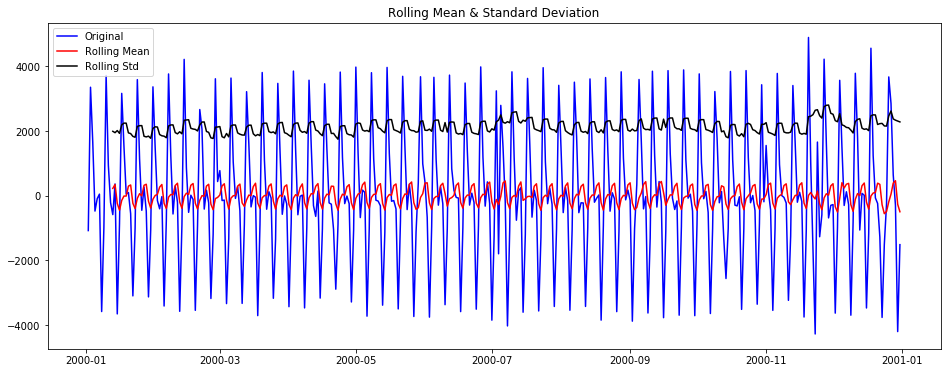

Results of Dickey-Fuller Test:
Test Statistic                -8.596890e+00
p-value                        7.038074e-14
#Lags Used                     1.300000e+01
Number of Observations Used    3.510000e+02
Critical Value (1%)           -3.449119e+00
Critical Value (10%)          -2.571176e+00
Critical Value (5%)           -2.869810e+00
dtype: float64


In [9]:
# test_stationarity(df['births'].diff(1).diff(7).dropna()[:365])
test_stationarity(df['births'].diff(1).dropna()[:365])

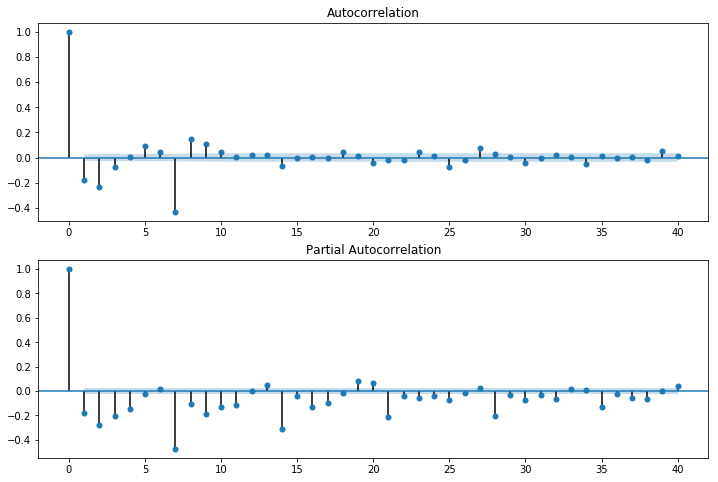

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['births'].diff(1).diff(7)[8:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['births'].diff(1).diff(7)[8:], lags=40, ax=ax2)
plt.show()

In [11]:
%%time

model_arima = pystan.StanModel(model_code='''
data {
  int<lower=1> N;           // number of observations used for fit
  int<lower=1> P;           // number of time lags of the autoregressive model
  int<lower=1> K;           // number of predictions
  real y[N+K];              // observed outputs
  
  real sigma_prior_location;
  real sigma_prior_scale;
}
parameters {
  vector[P] phi;            // autoregression coeff for P lags 
  real theta;               // moving avg coeff for lag 1
  real<lower=0> sigma;      // noise scale
}
model {
  vector[N] nu;             // prediction for time t
  vector[N] err;            // error for time t
  
  // Burn in for y[1..K], e.g. assume lags of y = mu, and err = 0
  for (t in 1:K) {
    for (p in 1:P) {
      nu[t] = 12000;
    }
    err[t] = y[t] - nu[t];
  }
  
  // Fit for y[K+1..N]
  for (t in K + 1:N) {
    nu[t] = 0;
    for (p in 1:P) {
      nu[t] = nu[t] + phi[p] * y[t - p];
    }
    nu[t] = nu[t] + theta * err[t - 1];
    err[t] = y[t] - nu[t];
  }

  // priors
  phi ~ normal(0, 1);
  theta ~ normal(0, 1);
  sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

  // likelihood
  err ~ normal(0, sigma);
}

generated quantities {
    vector[2 * K] y_pred;
    vector[2 * K] nu_pred;
    vector[2 * K] err_pred;
        
    real loglik = 0;
    
    // Copy the last K values onto new vector, and calculate the err
    for (t in 1:K) {
        y_pred[t] = y[N - K + t];
        nu_pred[t] = 0;
        for (p in 1:P) {
          nu_pred[t] = nu_pred[t] + phi[p] * y[N - K + t - p];
        }
        err_pred[t] = y_pred[t] - nu_pred[t];
    }
    
    // Predictions for the next K time steps.
    for (t in K + 1:2*K) {
        nu_pred[t] = 0;
        for (p in 1:P) {
          nu_pred[t] = nu_pred[t] + phi[p] * y_pred[t - p];
        }
        nu_pred[t] = nu_pred[t] + theta * err_pred[t - 1];
        err_pred[t] = err_pred[t - 1]; // Keep error term, as we don't know the error.
        
        y_pred[t] = normal_rng(nu_pred[t], sigma);        
        
        loglik += normal_lpdf(y[N - K + t] | nu_pred[t], sigma);
    }
}
''')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_edc957d2394985172b91cc2ec767ae8c NOW.


CPU times: user 1.31 s, sys: 54.5 ms, total: 1.37 s
Wall time: 55 s


In [12]:
def arima_priors_by_year_2000():
    df_2000 = births_2000s_df_with_index[lambda df: df.year == 2000]
    return df_2000.agg(['mean', 'std']).births

In [13]:
# i = 4
# priors = arima_priors_by_year_2000()
# data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
# data_for_model = {
#     'sigma_prior_location': priors['std'],
#     'sigma_prior_scale': .5 * priors['std'],            
#     'N': len(data['y_train']),
#     'P': 7,
#     'K': len(data['y_test']),
#     'y': np.concatenate([data['y_train'], data['y_test']])
# }
# print("data_for_model:", data_for_model)
# fit = model_arima.sampling(seed=COMMON_SEED, data=data_for_model, iter=500, chains=1)
# # y_pred = fit.extract()['y_pred'][:,-7:]
# # pred_err = y_pred.mean(axis=0) - data['y_test']

# check_convergence(fit)
# print(fit)

In [14]:
%%time

def arima_fit_separate_sliding_windows(persist_path, num_windows):
    if not os.path.exists(persist_path):
        os.mkdir(persist_path)
    all_prediction_errors = []
    priors = arima_priors_by_year_2000()
    for i in range(num_windows):
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
        fit = model_arima.sampling(seed=COMMON_SEED, data={
            'sigma_prior_location': priors['std'],
            'sigma_prior_scale': .5 * priors['std'],            
            'N': len(data['y_train']),
            'P': 7,
            'K': len(data['y_test']),
            'y': np.concatenate([data['y_train'], data['y_test']])
        }, iter=500, chains=1)
        check_convergence(fit)
        y_pred = fit.extract()['y_pred'][:,-7:]
        pred_err = y_pred.mean(axis=0) - data['y_test']
        all_prediction_errors.append(pred_err)
        with gzip.open(os.path.join(persist_path, 'fit%d_summary.pkl.gz' % i), 'wb') as f:
            pickle.dump(fit.summary(), f)
        with gzip.open(os.path.join(persist_path, 'fit%d_extract.pkl.gz' % i), 'wb') as f:
            pickle.dump(fit.extract(), f)         
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'wb') as f:
            pickle.dump(pred_err, f)        

arima_fit_separate_sliding_windows(persist_path='fit_arima', num_windows=52)

In [ ]:
def arima_evaluate_separate_sliding_windows(persist_path, num_windows):
    all_prediction_errors = []
    loglik = 0
    for i in range(num_windows):
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'rb') as f:
            pred_err = pickle.load(f)  
            all_prediction_errors.append(pred_err)
    for i in range(num_windows):
        with gzip.open(os.path.join(persist_path, 'fit%d_extract.pkl.gz' % i), 'rb') as f:
            params = pickle.load(f)  
            loglik += params['loglik'].mean()
    print('RMSE          :', rmse(np.concatenate(all_prediction_errors)))
    print('LogLikelyhood :', loglik)

arima_evaluate_separate_sliding_windows('fit_arima', 52)

In [ ]:
## 3183.485881533312

### Using Statsmodels ARIMA

In [ ]:
priors = arima_priors_by_year_2000()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
def statmodels_arima_fit_separate_sliding_windows(persist_path, num_windows):
    if not os.path.exists(persist_path):
        os.mkdir(persist_path)
    all_prediction_errors = []
    priors = arima_priors_by_year_2000()
    for i in range(num_windows):
        if os.path.exists(os.path.join(persist_path, 'fit%d_summary.pkl.gz' % i)):
            continue
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
        data_train = pd.Series(index = data['x_train'], data = data['y_train'].astype(float))
        data_test = pd.Series(index = data['x_test'], data = data['y_test'].astype(float))
        order = (7, 0, 1)
        model = ARIMA(data_train, order, freq='D')
        model = model.fit()
        print("i = ", i, "model = ", model.summary(), sep="\n")
        y_pred = model.predict(len(data_train), len(data_train) + len(data_test) - 1)
        pred_err = y_pred - data['y_test']
        loglik = model.llf
        all_prediction_errors.append(pred_err)     
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'wb') as f:
            pickle.dump(pred_err, f)        
        with gzip.open(os.path.join(persist_path, 'fit%d_loglik.pkl.gz' % i), 'wb') as f:
            pickle.dump(loglik, f)      

statmodels_arima_fit_separate_sliding_windows(persist_path = 'fit_arima_statmodels', num_windows = 4)

In [ ]:
def statmodels_arima_evaluate_separate_sliding_windows(persist_path, num_windows):
    all_prediction_errors = []
    loglik = 0
    for i in range(num_windows):
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'rb') as f:
            pred_err = pickle.load(f)  
            all_prediction_errors.append(pred_err)
    for i in range(num_windows):
        with gzip.open(os.path.join(persist_path, 'fit%d_loglik.pkl.gz' % i), 'rb') as f:
            params = pickle.load(f)  
            loglik += params
            
    print('RMSE          :', rmse(np.concatenate(all_prediction_errors)))
    print('LogLikelyhood :', loglik)

statmodels_arima_evaluate_separate_sliding_windows('fit_arima_statmodels', 52)